In [1]:
from __future__ import print_function

import os
import numpy as np
# import torch
# import pandas as pd
from io import StringIO
# from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
from keras.layers.advanced_activations import LeakyReLU
import random
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

Using TensorFlow backend.


# Load data from numpy arrays

In [2]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [3]:
num_features = 13
x_data, y_data = load_data_file(data_file='../../train/training_hela.npy', num_features=num_features)

In [4]:
Ntr = 70000
x_data_tr = x_data[:Ntr,:]
y_data_tr = y_data[:Ntr,:]
x_data_val = x_data[Ntr:,:]
y_data_val_un = y_data[Ntr:,:]

In [5]:
x_data.shape

(79999, 13)

# Training / Validation split

* Consider taking log 10 of data (Being careful not to take the log of the temperature features if they are included)

In [6]:
y_data.shape

(79999, 5)

In [7]:
# x_range = x_data.max(0) - x_data.min(0)
# y_range = y_data.max(0) - y_data.min(0)

## Normalise: remove mean and divide by standard deviation

In [8]:
# Normalise
x_data_tr = (x_data_tr - x_data.mean(0))/x_data.std(0)
x_data_val = (x_data_val - x_data.mean(0))/x_data.std(0)
# x_data_te = (x_data_te - x_data.mean(0))/x_data.std(0)

y_data_tr = (y_data_tr - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
y_data_val = (y_data_val_un - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
# y_data_te = (y_data_te - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]


# x_data_tr = (x_data_tr - x_data.min(0)) / ( x_range)
# x_data_val = (x_data_val - x_data.min(0)) / (x_range)

# y_data_tr = (y_data_tr - y_data.min(0)) / ( y_range)
# y_data_val = (y_data_val - y_data.min(0)) / (y_range)

In [9]:
x_data_tr = np.squeeze(x_data_tr)
x_data_val = np.squeeze(x_data_val)
# x_data_te = np.squeeze(x_data_te)

## For a CNN you need to add a channel at the end which is done in the cell below.
* If you want to use a FF NN, use the above cell and dont run the one below

In [10]:
# # CNN
# x_data_tr = np.expand_dims(x_data_tr,2)
# x_data_val = np.expand_dims(x_data_val,2)
# # x_data_te = np.expand_dims(x_data_val,2)

In [11]:
x_data_val.shape

(9999, 13)

In [12]:
y_data_val.shape

(9999, 5)

LL:  -1.1088045748743662  dropout =  0.5562902762770385  tau =  0.962580067045253
Epoch 00054: early stopping
LL:  -1.572217205474902  dropout =  0.3749374946295041  tau =  0.30016213465922464
LL:  -1.121014642804922  dropout =  0.40195074715481327  tau =  8.342936470924586
LL:  -1.0589275256590545  dropout =  0.6486616804219361  tau =  7.80375183440352
Epoch 00059: early stopping
LL:  -1.2157669419874964  dropout =  0.059014880156541986  tau =  8.713120267643509
LL:  -1.053428481570637  dropout =  0.5891716684613449  tau =  7.933771562069067
Epoch 00064: early stopping
LL:  -0.9829209969883663  dropout =  0.7  tau =  1.599744885407267
Epoch 00050: early stopping
LL:  -0.9332478470851929  dropout =  0.01  tau =  1.8981364553990525
Epoch 00054: early stopping
LL:  -0.9110325224011625  dropout =  0.01  tau =  2.7797118052702134
LL:  -0.894472304136759  dropout =  0.7  tau =  3.4700365389888943
Epoch 00057: early stopping
LL:  -0.9501924000183224  dropout =  0.01  tau =  3.93136131672537


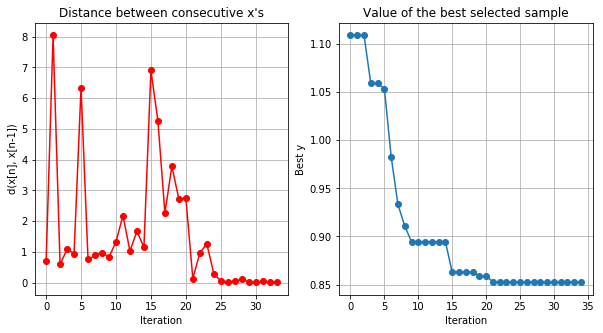

done with: [1024, 1024, 1024, 1024]


In [14]:
import GPyOpt
import time
from scipy.misc import logsumexp
class BNNModel:
    """
    Builds basic BNN model around training data
    """
    
    def __init__(self, X: np.array, Y: np.array, architecture: list, dropout = 0.1, T = 10, tau = 1.0, lengthscale = 1., base_lr = 5e-2, gamma = 0.0001*0.25):
        """
        :X: training data X -> so far only implemented for 1D data, needs to be of shape (n,1) or (1,n)
        :Y: training data y, needs to be passed as array of shape (n,1);
        :param architecture: list of perceptrons per layer, as long as network deep
        :param dropout: probability of perceptron being dropped out
        :param T: number of samples from posterior of weights during test time
        :param tau: precision of prior
        :param lengthscale: lengthscale
        :param base_lr: initial learning rate for SGD optimizer
        :param gamma: parameter for decay of initial learning rate according to default SGD learning schedule
        """
        if np.shape(X)[0] == len(Y):
            assert np.shape(X)[1] >= 1
        else:
            assert np.shape(X)[1] == len(Y)
            X = np.transpose(X)
            
        self.X = X
#         assert np.shape(Y)[1] == 1
        self.Y = Y
        
        self.dropout = dropout
        self.T = T
        self.tau = tau
        self.lengthscale = lengthscale 
        # Eq. 3.17 Gal thesis:
        self.weight_decay = ((1-self.dropout)*self.lengthscale**2)/(self.X.shape[0]*self.tau) # Don't need to dived by two as we are using squared error
        self.architecture = architecture
        
        self.model = Sequential()
        self.model.add(Dense(units=architecture[0], activation='relu', input_dim=np.shape(self.X)[1], kernel_regularizer=l2(self.weight_decay), bias_regularizer=l2(self.weight_decay)))
        self.model.add(Lambda(lambda x: K.dropout(x,level=self.dropout)))
        for jj in range(1,(len(architecture))):
            self.model.add(Dense(units=architecture[jj], activation='relu', kernel_regularizer=l2(self.weight_decay), bias_regularizer=l2(self.weight_decay)))
            self.model.add(Lambda(lambda x: K.dropout(x,level=self.dropout)))
        self.model.add(Dense(self.Y.shape[-1], activation='linear',W_regularizer=l2(self.weight_decay)))
#        sgd = SGD(lr=base_lr, decay=gamma, momentum=0.9, nesterov=True)
        self.model.compile(loss='mean_squared_error', optimizer='adam')

    
    def train(self, epochs = 100, batch_size = 128, validation_data = ()):
        """
        Trains model
        :param epochs: defines how many times each training point is revisited during training time
        :param batch_size: defines how big batch size used is
        """
        # Might want to save model check points?!
        Early_Stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
        historyBNN = self.model.fit(self.X, self.Y, epochs=epochs, batch_size=batch_size, verbose=0, validation_data = validation_data, callbacks=[Early_Stop])
#        tl,vl = historyBNN.history['loss'], historyBNN.history['val_loss'] 
        
    def predict(self, X_test):
        Yt_hat = np.array([self.model.predict(X_test, batch_size=500, verbose=0) for _ in range(self.T)])
#         Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        MC_pred = np.mean(Yt_hat, 0)
        return MC_pred, Yt_hat
    
    def evaluate(self, x_test, y_test):
#         rmse = np.mean((y_test.squeeze() - MC_pred.squeeze())**2.)**0.5
        _, Yt_hat = self.predict(x_test)
        # We compute the test log-likelihood
        ll = (logsumexp(-0.5 * self.tau * (y_test[None] - Yt_hat)**2., 0) - np.log(self.T) 
            - 0.5*np.log(2*np.pi) + 0.5*np.log(self.tau))
        test_ll = np.mean(ll)
        return test_ll


def BNN_objective_init(X_train, Y_train, layers ,lengthscale, T, X_val, Y_val,batch_size,epochs):
 
    def objective_function(solution):
        start_time = time.time()
#             solution = solution[0]
        bnn = BNNModel(X_train, Y_train, layers , dropout = solution[0][0], T=T , tau = solution[0][1], lengthscale = lengthscale)
        bnn.train(epochs = epochs, batch_size = batch_size, validation_data = (X_val,Y_val))
        ll  = bnn.evaluate(X_val,Y_val)
        print('LL: ',ll, ' dropout = ', solution[0][0], ' tau = ', solution[0][1])
        del bnn
        return -np.array(ll).reshape((1,1))
    return objective_function
 
# Variables
samples = 20 #number of samples of posterior weight distribution in BNNs
n_iters = 30
epochs = 64
T = 30
batch_size = 256
lengthscale = .01
# dropout = 0.1
# N_try = 200
# batch_size = 128
architectures = [[1024,1024,1024,1024]]
# [[1024,1024],
#                  [1024,1024,1024],
#                  [1024,1024,1024,1024],
#                  [1024,1024,1024,1024,1024]]

dropout_list = []
tau_list = []

for layers in architectures:
    objective_function = BNN_objective_init(x_data_tr, y_data_tr , layers ,lengthscale, T, x_data_val, y_data_val,batch_size,epochs)
     
    bounds = [{'name': 'dropout', 'type': 'continuous',  'domain': (0.01, 0.7), 'dimensionality': 1},
    {'name': 'tau', 'type': 'continuous',  'domain': (0.1, 10.0), 'dimensionality': 1}]
    opt_bnn = GPyOpt.methods.BayesianOptimization(objective_function, domain = bounds, batch_size=1, n_cores=1)
    opt_bnn.run_optimization(max_iter=n_iters)
    opt_score = min(opt_bnn.Y_best)
    opt_score_iter = list(opt_bnn.Y_best).index(opt_score)
    opt_solution = opt_bnn.X[opt_score_iter]
    dropout_list.append(opt_solution[0])
    tau_list.append(opt_solution[1])
    opt_bnn.plot_convergence()
    print('done with:',layers)

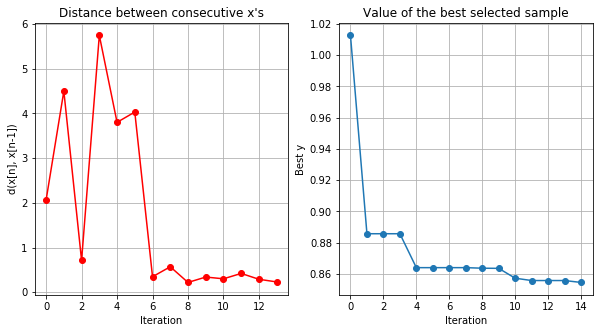

In [15]:
opt_bnn.plot_convergence()

In [19]:
opt_solution

array([0.17113893, 2.91552384])

In [17]:
opt_bnn.Y_best

array([1.0126289 , 0.8857782 , 0.8857782 , 0.8857782 , 0.86409204,
       0.86409204, 0.86409204, 0.86409204, 0.86373544, 0.86364198,
       0.85734285, 0.85584919, 0.85584919, 0.85584919, 0.85462965])

In [15]:
dropout_list

[0.3849066469992262]

In [16]:
tau_list

[3.359866969173832]

In [ ]:
# [0.16915591613892417,
#  0.013883232620015519,
#  0.03918105575234561,
#  0.2904996271130697]

In [ ]:
# [6.494351719359895, 3.3672096375467335, 7.099444382230575, 5.254537116468888]